In [1]:
# Ignoring warnings.
import warnings

warnings.filterwarnings('ignore')
# Imports, as always...

import pandas as pd
import numpy as np

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

# Beautification.
sns.set_context('paper')
sns.set_style('dark')
sns.set_palette('Set2')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set RNG.
torch.manual_seed(42)

# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
).to(device)

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Convergence

This notebook explores the convergence property of GNN architectures with differing residual connection methods, as trained in `training.ipynb` and defined in `./scripts/`.

## Loading Trained Models

In [2]:
# Settings shared across all models.
n_nodes = dataset.data.x.size(0)
model_depths = [1, 5, 10, 20]
aggregation_function = GCNConv
hid_dim = 64
dropout_ratio = .1
act_fn = F.relu

In [3]:
# Instantiating models of the correct architectural designs.
def instantiate_models():
    none_models = [
        models.BackboneModel(
            residual_method=None,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ] 
    fixed_models = [
        models.BackboneModel(
            residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    free_models = [
        models.BackboneModel(
            residual_method=models.FreeRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    hierarchical_models = [
        models.BackboneModel(
            residual_method=models.HierarchicalRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    cluster_models = [
        models.BackboneModel(
            residual_method=models.ClusterKeepingRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn,
            L_0=2 # Give an extra layer before cluster keeping.
        ).to(device)
        for depth in model_depths
    ]
    
    return none_models, fixed_models, free_models, hierarchical_models, cluster_models

none_models, fixed_models, free_models, hierarchical_models, cluster_models = instantiate_models()

In [4]:
def load_state_dicts():
    for model in none_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/none_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in fixed_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/fixed_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in free_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/free_{depth}.pt'))   
    
    # Too big to push to repo.
    for model in hierarchical_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/hierarchical_{depth}.pt'))   
        
    for model in cluster_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/cluster_{depth}.pt'))   
        
# Takes ~16s

load_state_dicts()

## Master Convergence Plot

In [6]:
# Generate the reduced features for each model at each depth (takes ~18s).
none_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in none_models
}
fixed_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in fixed_models
}
free_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in free_models
}
hierarchical_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in hierarchical_models
}
cluster_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in cluster_models
}

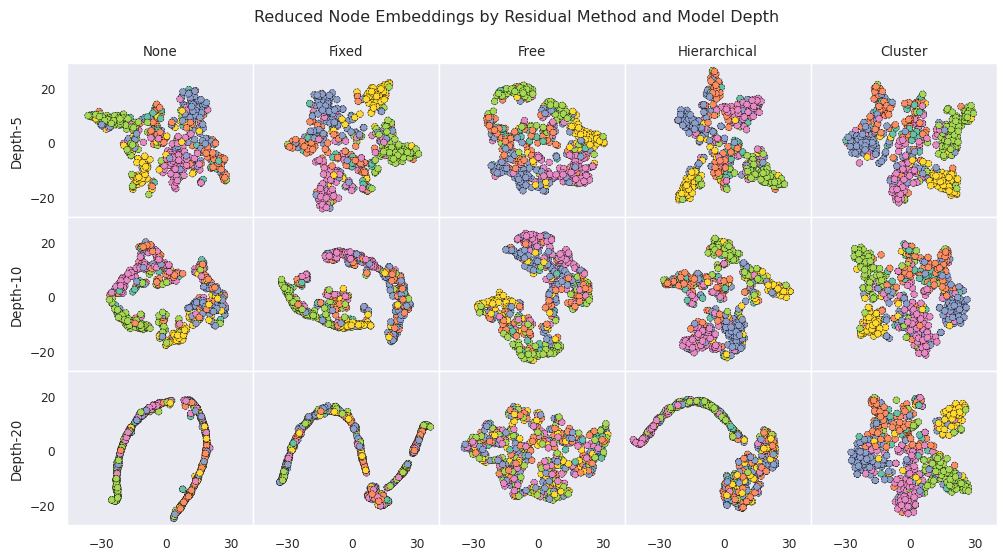

In [9]:
def draw_scatterplot(feature_df, ax):
    return sns.scatterplot(
        # Plot points and colour them.
        x=feature_df['dimension 1'],
        y=feature_df['dimension 2'],
        hue=feature_df['labels'],
        ax=ax,

        # Beautification.
        palette='Set2',
        linestyle='--',
        edgecolors='k'
    )

def draw_master_convergence_plot(save=True):
    # Put all subplots on the same axes scales.
    fig, axes = plt.subplots(3, 5, figsize=(12, 6), sharex='all', sharey='all')
    
    for row, depth in enumerate(model_depths[1:]):
        draw_scatterplot(none_reduced_features_by_depth[depth], axes[row][0])
        draw_scatterplot(fixed_reduced_features_by_depth[depth], axes[row][1])
        draw_scatterplot(free_reduced_features_by_depth[depth], axes[row][2])
        draw_scatterplot(hierarchical_reduced_features_by_depth[depth], axes[row][3])
        draw_scatterplot(cluster_reduced_features_by_depth[depth], axes[row][4])
        
    # Remove clutter.
    [[axes[i][j].legend([], [], frameon=False) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xlabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xticks([-30, 0, 30]) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_ylabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_yticks([-20, 0, 20]) for i in range(3)] for j in range(5)]
    
    # Add titles.
    [axes[0][i].set_title(['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster'][i]) for i in range(5)]
    [axes[i][0].set_ylabel(f'Depth-{model_depths[i+1]}') for i in range(3)]
    
    fig.suptitle('Reduced Node Embeddings by Residual Method and Model Depth', y=.97)
        
    # Save figure.
    plt.subplots_adjust(wspace=0, hspace=0)
    if save:
        plt.savefig('./figures/convergence/master.pdf', bbox_inches='tight')
    
draw_master_convergence_plot(True)

## Quantifying Convergence

We would like a nice numerical method to quantify how "converged" a graph has become. Intuitively, this method will be a function of the *spread of node representations*. There are a boat-load of metrics to choose from that do this:
- **Variance**, straight-forwardly measuring the variance of node representations around a centroid (i.e. graph-level representation);
- **Cosine similarity**, measuring the alignment of node representations;
- **Euclidean distance**, measuring the distance between nodes in the representation space; etc.

Spectral analysis may provide the most powerful way to measure convergence of nodes in the representation space. Again, there are different ways to do this.

In [10]:
def produce_embeddings(model: torch.nn.Module, data: torch_geometric.data.data.Data, mask: torch.Tensor) -> np.ndarray:
    # Into evaluation mode.
    model.eval()

    # Generate node embeddings (as a numpy array).
    embeddings = model.generate_node_embeddings(data.x, data.edge_index)[mask]
    return embeddings.detach().cpu().numpy()

produce_embeddings(cluster_models[0], dataset.data, dataset.data.val_mask)

array([[-2.005572 , -1.8390275, -2.067154 , -1.3562715, -1.5324705,
        -2.2416925],
       [-1.6667345, -1.8438449, -1.9624138, -1.9333076, -2.1255174,
        -1.3928343],
       [-2.0963945, -1.3048047, -1.8326797, -1.6878273, -2.4568613,
        -1.7414446],
       ...,
       [-1.8677361, -2.59401  , -1.4052657, -2.4330158, -1.7471154,
        -1.3338625],
       [-2.4437294, -1.6777811, -1.6418493, -1.308293 , -2.0797033,
        -1.9840903],
       [-1.5144656, -2.301084 , -2.0930228, -2.5372753, -1.2702364,
        -1.6257533]], dtype=float32)

## Quantifying 'Cluster Mixing'